# Data Preparation

This notebook contains all steps and decisions made in the 2nd iteration of the Austin Crime project.

## The Required Imports

Here we'll import all the required modules for this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import get_crime_data
import prepare
from wrangle import *

## Acquire the Data

We'll acquire the data using the get_crime_data function from the acquire module. Here we'll explicitly read from the source using an API, but going forward we will use the cache file 'Crime_Reports.csv'.

In [2]:
# Acquire the data using the API

df = get_crime_data()
df.shape

Using cached csv


(500000, 31)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   incident_report_number       500000 non-null  int64  
 1   crime_type                   500000 non-null  object 
 2   ucr_code                     500000 non-null  int64  
 3   family_violence              500000 non-null  object 
 4   occ_date_time                500000 non-null  object 
 5   occ_date                     500000 non-null  object 
 6   occ_time                     500000 non-null  int64  
 7   rep_date_time                500000 non-null  object 
 8   rep_date                     500000 non-null  object 
 9   rep_time                     500000 non-null  int64  
 10  location_type                498336 non-null  object 
 11  address                      500000 non-null  object 
 12  zip_code                     497118 non-null  float64
 13 

### Limit Time Frame of the Data

We are only interested in crimes reported between the years 2018 and 2021. Here we'll remove all observations that occur outside of this time frame.

In [4]:
# Let's see how the date information is stored in the dataframe.

df.head(1).occ_date

0    2022-05-28T00:00:00.000
Name: occ_date, dtype: object

In [5]:
# Set the occ_date column to a datetime type.

df.occ_date = pd.to_datetime(df.occ_date, format = '%Y-%m-%d')

In [6]:
df.occ_date.head()

0   2022-05-28
1   2022-05-28
2   2022-05-28
3   2022-05-28
4   2022-05-28
Name: occ_date, dtype: datetime64[ns]

In [7]:
# Subset the data to include observations between 2018-01-01 and 2021-12-31.

df = df[(df.occ_date >= '2018-01-01') & (df.occ_date <= '2021-12-31')]
df.shape

(401978, 31)

### New Decisions

*After discussion and research on the meaning of cleared by exception, we decided that instead of lumping cleared by arrest and cleared by exception together it might be better to drop cleared by exception all together. Cleared by exception and cleared by arrest can mean very different things, so depending on the proportion of cleared by exception values it may make sense to drop all of them for the sake of data integrity.*

In [8]:
# Checking the proportions of cleared by arrest, cleared by exception, and not cleared
df.clearance_status.value_counts()

N    281250
C     73852
O      1668
Name: clearance_status, dtype: int64

In [9]:
# Checking as a percentage
df.clearance_status.value_counts(normalize=True)

N    0.788323
C    0.207002
O    0.004675
Name: clearance_status, dtype: float64

**Cleared by exception makes up less than 1 percent of our data. Moving forward We will drop all rows with these values.**

In [10]:
# Removing the O value meaning cleared by exception
df = df[~(df.clearance_status == 'O')]

In [11]:
df.clearance_status.value_counts()

N    281250
C     73852
Name: clearance_status, dtype: int64

**Testing this change after adding it to the prepare.py**

In [12]:
df = wrangle_crime_data(drop_cleared_by_exception=True)
df.head()

Using cached csv


,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
34573,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,GE,3,30.263739,-97.743651,cleared by arrest,2022-01-03,True,0 days 00:00:00
34574,THEFT,N,2021-12-31 23:50:00,2021-12-31,2022-01-07 14:12:00,2022-01-07,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,30.215264,-97.703019,not cleared,2022-01-10,False,6 days 14:22:00
34575,PUBLIC INTOXICATION,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,GE,2,30.267300,-97.738857,cleared by arrest,2021-12-31,True,0 days 00:00:00
34576,DOC DISCHARGE GUN - PUB PLACE,N,2021-12-31 23:47:00,2021-12-31,2021-12-31 23:47:00,2021-12-31,RESIDENCE / HOME,1202 E ST JOHNS AVE,78752.0,4.0,ID,1,30.328049,-97.693683,not cleared,2022-01-05,False,0 days 00:00:00
34577,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31 23:40:00,2021-12-31,2022-01-01 00:44:00,2022-01-01,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,ED,1,30.369262,-97.695105,not cleared,2022-01-05,False,0 days 01:04:00


In [13]:
df.clearance_status.value_counts()

not cleared          275577
cleared by arrest     72431
Name: clearance_status, dtype: int64

In [14]:
df.shape

(348008, 18)

### Try joining our data set with the Austin Police Department Districts Data Set

#### Acquire the Department Districts Set

In [15]:
districts_df = pd.read_csv('Austin_Police_Department_Districts_data.csv')
districts_df.head()

,the_geom,OBJECTID,DISTRICT_NAME,SORT_ORDER,BATTALION_ID,JURISDICTION_ID,COLOR,CODE,EXTERNAL_KEY,BATTALION_CODE,...,INPUT_DATE,MODIFIED_DATE,INPUT_BY,MODIFIED_BY,BUREAU_NAME,PATROL_AREA,COMMAND_PHONE_NUMBER,PRIMARY_KEY,Shape__Area,Shape__Length
0,MULTIPOLYGON (((-97.827136391606 30.4558508283...,73,ADAM 8,1,21,6,16744448,1271,1271,A1,...,12/22/2014 11:31:16 AM +0000,10/18/2021 02:45:02 PM +0000,bmartinlimuel,APD_ADMIN,NORTH,NORTHWEST,512-974-5500,6,5.172025e+08,191833.208798
1,MULTIPOLYGON (((-97.766313673553 30.4663198555...,71,ADAM 4,1,21,6,16744448,1272,1272,A1,...,10/09/2018 01:39:46 PM +0000,10/09/2018 01:43:24 PM +0000,APD_ADMIN,APD_ADMIN,NORTH,NORTHWEST,512-974-5500,76,6.959435e+07,47235.701679
2,MULTIPOLYGON (((-97.682787782506 30.2120013978...,69,HENRY 6,1,205,59,16711808,1302,1302,H1,...,12/22/2014 11:31:16 AM +0000,10/09/2018 01:43:49 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHCENTRAL,512-974-8106,80,8.660023e+07,45199.006624
3,MULTIPOLYGON (((-97.66368813346 30.44938993670...,66,EDWARD 6,1,174,13,16711680,1291,1291,E1,...,12/22/2014 11:31:16 AM +0000,09/02/2020 03:12:28 PM +0000,bmartinlimuel,ap7657,CENTRAL,NORTHEAST,512-974-5500,46,1.448894e+08,108031.797015
4,MULTIPOLYGON (((-97.645897670865 30.3879205146...,72,EDWARD 5,1,174,13,16711680,1288,1288,E1,...,12/22/2014 11:31:16 AM +0000,09/09/2021 01:56:20 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,25,1.134741e+08,72532.628909


In [16]:
districts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              90 non-null     object 
 1   OBJECTID              90 non-null     int64  
 2   DISTRICT_NAME         90 non-null     object 
 3   SORT_ORDER            90 non-null     int64  
 4   BATTALION_ID          90 non-null     int64  
 5   JURISDICTION_ID       90 non-null     int64  
 6   COLOR                 90 non-null     int64  
 7   CODE                  90 non-null     int64  
 8   EXTERNAL_KEY          90 non-null     int64  
 9   BATTALION_CODE        90 non-null     object 
 10  SECTOR_NAME           90 non-null     object 
 11  INPUT_DATE            90 non-null     object 
 12  MODIFIED_DATE         90 non-null     object 
 13  INPUT_BY              90 non-null     object 
 14  MODIFIED_BY           90 non-null     object 
 15  BUREAU_NAME           82 

#### Summarize the Null Values

In [17]:
prepare.attribute_nulls(districts_df)

,rows_missing,percent_missing
the_geom,0,0.000000
OBJECTID,0,0.000000
DISTRICT_NAME,0,0.000000
SORT_ORDER,0,0.000000
BATTALION_ID,0,0.000000
JURISDICTION_ID,0,0.000000
COLOR,0,0.000000
CODE,0,0.000000
EXTERNAL_KEY,0,0.000000
BATTALION_CODE,0,0.000000


**Phone number is unimportant to us but let's check on the bureau name.**

In [18]:
districts_df.BUREAU_NAME.value_counts(dropna=False)

SOUTH      29
CENTRAL    28
NORTH      25
NaN         8
Name: BUREAU_NAME, dtype: int64

In [19]:
# Let's look at the data set where I have the nan values
districts_df[districts_df.BUREAU_NAME.isna()]

,the_geom,OBJECTID,DISTRICT_NAME,SORT_ORDER,BATTALION_ID,JURISDICTION_ID,COLOR,CODE,EXTERNAL_KEY,BATTALION_CODE,...,INPUT_DATE,MODIFIED_DATE,INPUT_BY,MODIFIED_BY,BUREAU_NAME,PATROL_AREA,COMMAND_PHONE_NUMBER,PRIMARY_KEY,Shape__Area,Shape__Length
19,MULTIPOLYGON (((-97.670871493106 30.1931992460...,24,STS,0,519,145,16776960,1334,1334,APT3,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,48,1.398689e+04,478.708731
31,MULTIPOLYGON (((-97.667607670305 30.2174676056...,58,LND,0,518,145,16776960,1333,1333,APT2,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,52,1.884170e+07,28746.650215
49,MULTIPOLYGON (((-97.674271697668 30.2181401372...,48,AOA,0,520,145,16776960,1336,1336,APT4,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,39,1.348928e+08,121793.575921
59,MULTIPOLYGON (((-97.670871493106 30.1931992460...,25,STP,0,519,145,16776960,1335,1335,APT3,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,49,1.456751e+04,489.755286
63,MULTIPOLYGON (((-97.658643580705 30.2124379324...,59,LND,0,518,145,16776960,1333,1333,APT2,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,53,1.307077e+07,28596.731885
69,MULTIPOLYGON (((-97.66876018898 30.19775958306...,23,PUBLIC,0,520,145,16776960,1337,1337,APT4,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,47,7.853923e+06,46434.049852
81,MULTIPOLYGON (((-97.664387280505 30.2024460131...,26,MTS,0,517,145,16776960,1331,1331,APT1,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,50,2.615852e+05,4759.322426
83,MULTIPOLYGON (((-97.665862302277 30.2023008824...,27,MTP,0,517,145,16776960,1332,1332,APT1,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NaN,ABIA,NaN,51,4.420677e+04,1679.192640


**It looks like there may be a way to impute the missing bureau names here but the column may also be unneccesary considering all of the other location data I have. For now I will press on without imputing or dropping the nulls.**

### Join districts_df with out main data set

In [20]:
main_df = df.copy()

*For ease of use I'm going to do some basic prep of the column names.*

In [21]:
districts_df.columns = districts_df.columns.str.strip().str.lower().str.replace('__', ('_'))
districts_df.columns

Index(['the_geom', 'objectid', 'district_name', 'sort_order', 'battalion_id',
       'jurisdiction_id', 'color', 'code', 'external_key', 'battalion_code',
       'sector_name', 'input_date', 'modified_date', 'input_by', 'modified_by',
       'bureau_name', 'patrol_area', 'command_phone_number', 'primary_key',
       'shape_area', 'shape_length'],
      dtype='object')

*I think I'll be merging using the sector and district combined and the district_name column. Let me investigate these further to check feasability.*

In [22]:
main_df.sector.value_counts()

ED    49760
DA    45050
FR    42534
AD    41851
BA    37392
CH    36004
HE    35914
ID    35559
GE    21697
AP     1496
88      607
UT      144
Name: sector, dtype: int64

In [23]:
districts_df.sector_name.value_counts()

HENRY      12
BAKER      12
CHARLIE    12
ADAM        9
DAVID       9
EDWARD      8
FRANK       8
IDA         8
APT         8
GEORGE      4
Name: sector_name, dtype: int64

In [24]:
districts_df.district_name.unique()

array(['ADAM 8', 'ADAM 4', 'HENRY 6', 'EDWARD 6', 'EDWARD 5', 'ADAM 6',
       'FRANK 7', 'FRANK 4', 'FRANK 8', 'IDA 2', 'BAKER 8', 'FRANK 6',
       'FRANK 3', 'ADAM 5', 'DAVID 3', 'EDWARD 1', 'GEORGE 4', 'DAVID 1',
       'HENRY 5', 'STS', 'EDWARD 7', 'FRANK 1', 'DAVID 5', 'CHARLIE 3',
       'A1 UT', 'DAVID 2', 'BAKER 4', 'C8 UT-3', 'HENRY 7', 'CHARLIE 8',
       'B1 UT-2', 'LND', 'ADAM 3', 'C8 UT-1', 'CHARLIE 2', 'HENRY 8',
       'EDWARD 4', 'DAVID 7', 'CHARLIE 1', 'DAVID 6', 'DAVID 4',
       'EDWARD 8', 'GEORGE 1', 'IDA 5', 'HENRY 4', 'AOA', 'CHARLIE 4',
       'FRANK 5', 'C8 UT-2', 'BAKER 1', 'DAVID PARK PD', 'BAKER 2',
       'GEORGE 2', 'IDA 6', 'GEORGE 3', 'STP', 'HENRY 3', 'EDWARD 2',
       'IDA 3', 'BAKER 5', 'B7 UT', 'DAVID 8', 'CHARLIE 5', 'PUBLIC',
       'CHARLIE 7', 'EDWARD 3', 'IDA 4', 'ADAM 2', 'BAKER PARK PD',
       'IDA 7', 'BAKER 6', 'BAKER 7', 'ADAM 7', 'IDA 1', 'BAKER 3', 'MTS',
       'FRANK 2', 'MTP', 'ADAM 1', 'CHARLIE 6', 'HENRY 1', 'IDA 8',
       'HENRY

**I'm going to have the convert the sector values from their abbreviated versions to the full names to match the district_name in districts_df.**

*I'm able to match most of the abbreviations but am not sure what AP, or 88 represents. I may decide to drop these since it makes up a small amount of data. UT mostl likely referes to the college campus but the correlated value in districts_df is formatted inconsistently (i.e A1 UT, B1 UT-2) making it difficult to come up with a way to join them. I may end up dropping these as well.*

In [25]:
# Change the values in sectors to more closely match those in distrcits_df
sectors = {'ED':'EDWARD', 'DA':'DAVID', 'FR':'FRANK', 'AD':'ADAM', 
           'BA':'BAKER', 'CH':'CHARLIE', 'HE':'HENRY', 'ID':'IDA',
          'GE':'GEORGE', 'AP': 'APT', '88':'88', 'UT':'UT'}

main_df['sector'] = main_df.sector.map(sectors)

In [26]:
main_df.sector.value_counts()

EDWARD     49760
DAVID      45050
FRANK      42534
ADAM       41851
BAKER      37392
CHARLIE    36004
HENRY      35914
IDA        35559
GEORGE     21697
APT         1496
88           607
UT           144
Name: sector, dtype: int64

**Now let's make a column that combines the sector with the district number to match the format in districts_df.**

In [27]:
main_df.district.value_counts()

2     69144
1     65263
3     42435
4     42051
5     35573
7     34602
6     33123
8     23553
S       980
88      607
D       383
B       122
A        71
P        68
C        33
Name: district, dtype: int64

In [28]:
# Cobine the two columns into one called pd_district to match column in other data set
main_df['pd_district'] = main_df['sector'].astype(str) + ' ' + df['district'].astype(str)

In [29]:
main_df.pd_district.unique()

array(['GEORGE 3', 'HENRY 5', 'GEORGE 2', 'IDA 1', 'EDWARD 1', 'EDWARD 7',
       'GEORGE 1', 'CHARLIE 2', 'HENRY 6', 'IDA 2', 'HENRY 2', 'HENRY 3',
       'ADAM 6', 'ADAM 1', 'DAVID 1', 'FRANK 5', 'IDA 8', 'CHARLIE 5',
       'FRANK 4', 'DAVID 6', 'FRANK 7', 'ADAM 2', 'CHARLIE 1', 'HENRY 8',
       'BAKER 1', 'ADAM 3', 'EDWARD 6', 'EDWARD 2', 'CHARLIE 4',
       'EDWARD 8', 'DAVID 2', 'ADAM 5', 'CHARLIE 3', 'DAVID 4',
       'EDWARD 4', 'BAKER 3', 'DAVID 5', 'DAVID 3', 'BAKER 4', 'FRANK 6',
       'FRANK 3', 'HENRY 4', 'ADAM 7', 'IDA 3', 'FRANK 8', 'BAKER 8',
       'FRANK 1', 'APT S', 'CHARLIE 8', 'ADAM 8', 'BAKER 6', 'IDA 7',
       'EDWARD 5', 'CHARLIE 7', 'IDA 5', 'FRANK 2', '88 88', 'BAKER 5',
       'HENRY 1', 'ADAM 4', 'IDA 6', 'BAKER 2', 'DAVID 7', 'BAKER 7',
       'EDWARD 3', 'DAVID 8', 'IDA 4', 'APT D', 'CHARLIE 6', 'HENRY 7',
       'GEORGE 4', 'APT A', 'UT B', 'APT P', 'APT C', 'UT C', 'UT A',
       'DAVID D'], dtype=object)

**The values in our two columns now look pretty similar. I'll go ahead and merge the df's with an inner join which will drop all the rows where there is no match. Rows without a match should include only APT, 88, and UT sectors which represents a very small proportion of the data. So I'm not concerned about losing too much data after the merge.**

*In the future, I may try to find a way to maintain the UT sectors.*

In [30]:
## Let's go ahead and merge the data sets
merged = main_df.merge(districts_df, left_on= ['pd_district'], right_on= ['district_name'])
merged.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,...,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length
0,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
1,ASSAULT BY CONTACT,N,2021-12-31 12:45:00,2021-12-31,2022-01-04 17:07:00,2022-01-04,BAR / NIGHTCLUB,78 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
2,ASSAULT WITH INJURY,N,2021-12-31 11:00:00,2021-12-31,2022-01-05 19:17:00,2022-01-05,RESIDENCE / HOME,51 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
3,THEFT,N,2021-12-31 02:00:00,2021-12-31,2022-02-01 22:52:00,2022-02-01,BAR / NIGHTCLUB,76 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
4,ASSAULT BY CONTACT,N,2021-12-30 08:29:00,2021-12-30,2021-12-30 08:29:00,2021-12-30,HOTEL / MOTEL / ETC.,20 N IH 35 SVRD SB,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845


In [31]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352931 entries, 0 to 352930
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   crime_type            352931 non-null  object         
 1   family_violence       352931 non-null  object         
 2   occurrence_time       352931 non-null  datetime64[ns] 
 3   occurrence_date       352931 non-null  datetime64[ns] 
 4   report_time           352931 non-null  datetime64[ns] 
 5   report_date           352931 non-null  datetime64[ns] 
 6   location_type         352931 non-null  object         
 7   address               352931 non-null  object         
 8   zip_code              352931 non-null  float64        
 9   council_district      352931 non-null  float64        
 10  sector                352931 non-null  object         
 11  district              352931 non-null  object         
 12  latitude              352931 non-null  float

#### Let me try the same merge using just the sector name

In [32]:
main_df.sector.value_counts()

EDWARD     49760
DAVID      45050
FRANK      42534
ADAM       41851
BAKER      37392
CHARLIE    36004
HENRY      35914
IDA        35559
GEORGE     21697
APT         1496
88           607
UT           144
Name: sector, dtype: int64

In [33]:
districts_df.sector_name.value_counts()

HENRY      12
BAKER      12
CHARLIE    12
ADAM        9
DAVID       9
EDWARD      8
FRANK       8
IDA         8
APT         8
GEORGE      4
Name: sector_name, dtype: int64

In [34]:
## Let me also try a merge only using sector name
sector_merge = main_df.merge(districts_df, left_on= ['sector'], right_on= ['sector_name'])
sector_merge.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,...,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length
0,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,33,3.501785e+06,7850.762882
1,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,09/18/2019 11:53:42 AM +0000,bmartinlimuel,APD_ADMIN,NORTH,DTAC,512-974-5203,54,1.649662e+07,22440.194852
2,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:53 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,19,3.600168e+06,7922.102059
3,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
4,PUBLIC INTOXICATION,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,05/27/2016 01:55:16 PM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,33,3.501785e+06,7850.762882


In [35]:
sector_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215409 entries, 0 to 3215408
Data columns (total 40 columns):
 #   Column                Dtype          
---  ------                -----          
 0   crime_type            object         
 1   family_violence       object         
 2   occurrence_time       datetime64[ns] 
 3   occurrence_date       datetime64[ns] 
 4   report_time           datetime64[ns] 
 5   report_date           datetime64[ns] 
 6   location_type         object         
 7   address               object         
 8   zip_code              float64        
 9   council_district      float64        
 10  sector                object         
 11  district              object         
 12  latitude              float64        
 13  longitude             float64        
 14  clearance_status      object         
 15  clearance_date        datetime64[ns] 
 16  cleared               bool           
 17  time_to_report        timedelta64[ns]
 18  pd_district           

In [36]:
# Compare the shapes of my original df with the merged df, and sector df
df.shape, merged.shape, sector_merge.shape

((348008, 18), (352931, 40), (3215409, 40))

**Merging with using the new column I created reatains the most amount of data so I'll keep that for now. 
Now that the two data sets are merged I want to see what values have been dropped and see the distributions of new columns.**

In [37]:
merged.district_name.unique()

array(['GEORGE 3', 'HENRY 5', 'GEORGE 2', 'IDA 1', 'EDWARD 1', 'EDWARD 7',
       'GEORGE 1', 'CHARLIE 2', 'HENRY 6', 'IDA 2', 'HENRY 2', 'HENRY 3',
       'ADAM 6', 'ADAM 1', 'DAVID 1', 'FRANK 5', 'IDA 8', 'CHARLIE 5',
       'FRANK 4', 'DAVID 6', 'FRANK 7', 'ADAM 2', 'CHARLIE 1', 'HENRY 8',
       'BAKER 1', 'ADAM 3', 'EDWARD 6', 'EDWARD 2', 'CHARLIE 4',
       'EDWARD 8', 'DAVID 2', 'ADAM 5', 'CHARLIE 3', 'DAVID 4',
       'EDWARD 4', 'BAKER 3', 'DAVID 5', 'DAVID 3', 'BAKER 4', 'FRANK 6',
       'FRANK 3', 'HENRY 4', 'ADAM 7', 'IDA 3', 'FRANK 8', 'BAKER 8',
       'FRANK 1', 'CHARLIE 8', 'ADAM 8', 'BAKER 6', 'IDA 7', 'EDWARD 5',
       'CHARLIE 7', 'IDA 5', 'FRANK 2', 'BAKER 5', 'HENRY 1', 'ADAM 4',
       'IDA 6', 'BAKER 2', 'DAVID 7', 'BAKER 7', 'EDWARD 3', 'DAVID 8',
       'IDA 4', 'CHARLIE 6', 'HENRY 7', 'GEORGE 4'], dtype=object)

<AxesSubplot:>

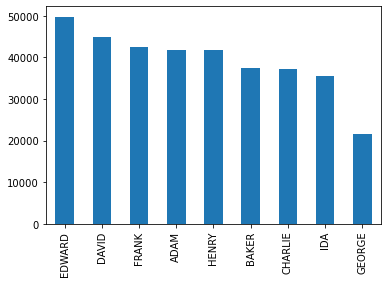

In [38]:
merged.sector.value_counts().plot.bar()

In [39]:
merged.district.value_counts()

2    69144
1    65263
3    42435
4    42051
7    38682
5    35573
6    33123
8    26660
Name: district, dtype: int64

<AxesSubplot:>

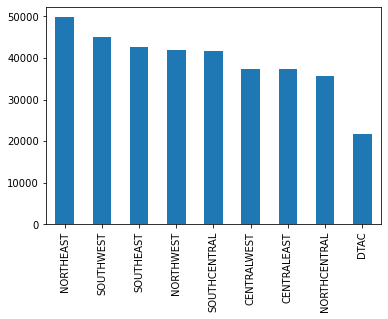

In [40]:
merged.patrol_area.value_counts().plot.bar()

<AxesSubplot:>

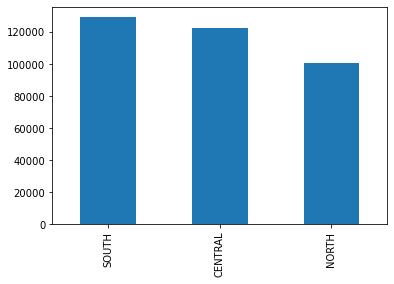

In [41]:
merged.bureau_name.value_counts().plot.bar()

### Create functions that replicate acquiring and merging the new data set

**First I'll just replicate the merge so I can start exploring. I'll worry about automating the acquisition later.**

In [42]:
def merge_districts(df):
    # Acquire our two dfs to be merged
    main_df = df.copy()
    districts_df = pd.read_csv('Austin_Police_Department_Districts_data.csv')
    
    # Clean up the columns in districts_df to match format of main_df
    districts_df.columns = districts_df.columns.str.strip().str.lower().str.replace('__', ('_'))
    
    # Change the values in sectors to more closely match those in distrcits_df
    sectors = {'ED':'EDWARD', 'DA':'DAVID', 'FR':'FRANK', 'AD':'ADAM', 
               'BA':'BAKER', 'CH':'CHARLIE', 'HE':'HENRY', 'ID':'IDA',
               'GE':'GEORGE', 'AP': 'APT', '88':'88', 'UT':'UT'}

    main_df['sector'] = main_df.sector.map(sectors)
    
    # Cobine the two columns into one called pd_district to match column in other data set
    main_df['pd_district'] = main_df['sector'].astype(str) + ' ' + df['district'].astype(str)
    
    # Merge the data sets using the newly created column in main_df
    merged = main_df.merge(districts_df, left_on= ['pd_district'], right_on= ['district_name'])
    
    return merged 
    
    
    
    
    
    

In [43]:
new_df = merge_districts(df)
new_df.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,...,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length
0,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
1,ASSAULT BY CONTACT,N,2021-12-31 12:45:00,2021-12-31,2022-01-04 17:07:00,2022-01-04,BAR / NIGHTCLUB,78 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
2,ASSAULT WITH INJURY,N,2021-12-31 11:00:00,2021-12-31,2022-01-05 19:17:00,2022-01-05,RESIDENCE / HOME,51 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
3,THEFT,N,2021-12-31 02:00:00,2021-12-31,2022-02-01 22:52:00,2022-02-01,BAR / NIGHTCLUB,76 RAINEY ST,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845
4,ASSAULT BY CONTACT,N,2021-12-30 08:29:00,2021-12-30,2021-12-30 08:29:00,2021-12-30,HOTEL / MOTEL / ETC.,20 N IH 35 SVRD SB,78701.0,9.0,...,12/22/2014 11:31:16 AM +0000,03/03/2017 08:32:07 AM +0000,bmartinlimuel,ap7657,NORTH,DTAC,512-974-5203,12,8.371570e+06,14491.846845


In [44]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352931 entries, 0 to 352930
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   crime_type            352931 non-null  object         
 1   family_violence       352931 non-null  object         
 2   occurrence_time       352931 non-null  datetime64[ns] 
 3   occurrence_date       352931 non-null  datetime64[ns] 
 4   report_time           352931 non-null  datetime64[ns] 
 5   report_date           352931 non-null  datetime64[ns] 
 6   location_type         352931 non-null  object         
 7   address               352931 non-null  object         
 8   zip_code              352931 non-null  float64        
 9   council_district      352931 non-null  float64        
 10  sector                352931 non-null  object         
 11  district              352931 non-null  object         
 12  latitude              352931 non-null  float